# Probabilistic Programming in Pyro

In [237]:
import os
import random

import numpy
import torch

import torch.nn as nn
import torch.nn.functional as torch_functional
import torchvision.transforms as transforms

from torch.utils.data import Dataset
from torch.utils.data import DataLoader

import pyro
import pyro.distributions as dist
import pyro.contrib.examples.util  # patches torchvision
from pyro.contrib.examples.util import MNIST
from pyro.infer import SVI, Trace_ELBO
from pyro.optim import Adam

import matplotlib.pyplot as plt


# Set seeds for reproducibility
torch.manual_seed(0)
pyro.set_rng_seed(0)

[Pyro](https://pyro.ai/) is a universal probabilistic programming language built in Python that uses PyTorch as its backend. Among its advantages are that it's:
 + **Universal**: it can represent any computable probability distribution
 + **Scalable**: scales to large data sets with little overhead
 + **Minimal**: implemented with a small core of powerful, composable abstractions
 
A feature of Pyro making it particularly appealing is the ease in developing deep probabilistic models. Seamless integration with PyTorch makes this task trivial in Pyro, thus bridging the world of Bayesian modelling and deep learning. To illustrate this we'll develop an implementation of the Variational Autoencoder (VAE) first in PyTorch, and follow that up with an implementation in Pyro. This will allow us to objectively assess the advantages/disadvantages of one or the other approach. 

# VAE: A Refresher on Theory
The variational autoencoder (VAE) is arguably the simplest setup that realizes deep probabilistic modeling. Below can be seen a PGM of the simplest form of the model. Having observed $N$ data points denoted $x_i$, we pose a model where each datapoint is generated by a latent random variable $z_i$. There is also a parameter $\theta$, which is global in the sense that all the datapoints depend on it.

<img src="https://pyro.ai/examples/_static/img/vae_model.png" alt="drawing" width="300"/>

We allow $x_i$ to depend on $z_i$ in a complex, non-linear way, and this mapping is usually implemented with a deep neural network with parameters $\theta$. This complexity makes the models more powerful, but also makes inference more challenging. The joint distribution can be factorized as:
$$
    p(\mathbf{x}, \mathbf{z}) = \prod_{i=1}^N p_{\theta} (\mathbf{x}_i \mid \mathbf{z}_i) p (\mathbf{z}_i)
$$

The job of inference is to recover a "sensible" posterior over the latent variables. Just as $x_i$ depends on $z_i$ in a complex way, so might we expect the posterior over $z_i$s to be complex, and inference challenging. Working under the dome of variational inference, we need to define a family of distribution as potential posteriors over the latents. 

We'll use ***amortized inference***. In amortized inference we introduce a single set of variational parameters $\phi$ for **ALL** data points. The alternative would be to have variational parameters $\lambda_i$ for each data point. This would, however, make it impossible to scale to large datasets, as also the parameter space would explode in size. To parameterize the variational family we'll use a deep neural network.

<img src="https://pyro.ai/examples/_static/img/vae_guide.png" alt="drawing" width="300"/>

# The ABCs of PyTorch
Before diving into the PyTorch implementation of the VAE, we'll look at some core concepts and abstractions in PyTorch.

### Tensors
Tensors are a specialized data structure that are very similar to arrays and matrices. Other representations of arrays and matrices you might have seen in Python are in numpy, for example. In PyTorch tensors are used to encode the inputs and outputs of a model, as well as the model’s parameters. 

Unlike arrays in numpy, Torch tensors can *run on GPUs or other hardware accelerators*, and are also optimized for *automatic differentiation*, which are and were both fundamental for the flourishing of deep learning in recent decades. 

In [239]:
# Create a tensor from an nested list of numbers
data = [[1, 2],[3, 4]]
x_data = torch.Tensor(data)
print(f"Tensor from list: {x_data}")
print()

# Convert a numpy array to a tensor
np_array = numpy.array(data)
x_np = torch.from_numpy(np_array)
print(f"Tensor from NP array: {x_np}")
print()

# Convert a tensor to a numpy array
np_array_tensor = x_np.numpy()
print(f"Numpy array from Tensor: {np_array_tensor}")

Tensor from list: tensor([[1., 2.],
        [3., 4.]])

Tensor from NP array: tensor([[1, 2],
        [3, 4]])

Numpy array from Tensor: [[1 2]
 [3 4]]


In [242]:
shape = (2,3,)

rand_tensor = torch.rand(shape)  # A tensor of random numbers from the Uniform distribution on [0, 1)
ones_tensor = torch.ones(shape)  # A tensor of 1s
zeros_tensor = torch.zeros(shape)  # A tensor of 0s

print(f"Random tensor: {rand_tensor}")
print(f"Ones tensor: {ones_tensor}")
print(f"Zeros tensor: {zeros_tensor}")

print()
print("The properties of a tensor:")
print(f"Shape of tensor: {rand_tensor.shape}")
print(f"Datatype of tensor: {rand_tensor.dtype}")
print(f"Device tensor is stored on: {rand_tensor.device}")

Random tensor: tensor([[0.8198, 0.9971, 0.6984],
        [0.5675, 0.8352, 0.2056]])
Ones tensor: tensor([[1., 1., 1.],
        [1., 1., 1.]])
Zeros tensor: tensor([[0., 0., 0.],
        [0., 0., 0.]])

The properties of a tensor:
Shape of tensor: torch.Size([2, 3])
Datatype of tensor: torch.float32
Device tensor is stored on: cpu


In [244]:
# We move our tensor to the GPU if available
if torch.cuda.is_available():
    rand_tensor = rand_tensor.to("cuda")
    
print(f"Device tensor is stored on: {rand_tensor.device}")


tensor = torch.ones(4, 4)

print()
print("Indexing and slicing:")
print(f"First row: {tensor[0]}")
print(f"First column: {tensor[:, 0]}")
print(f"Last column: {tensor[..., -1]}")

tensor[:,1] = 0
print(tensor)

Device tensor is stored on: cpu

Indexing and slicing:
First row: tensor([1., 1., 1., 1.])
First column: tensor([1., 1., 1., 1.])
Last column: tensor([1., 1., 1., 1.])
tensor([[1., 0., 1., 1.],
        [1., 0., 1., 1.],
        [1., 0., 1., 1.],
        [1., 0., 1., 1.]])
tensor([[3., 3., 3., 3.],
        [3., 3., 3., 3.],
        [3., 3., 3., 3.],
        [3., 3., 3., 3.]])


tensor([[1., 0., 1., 1.],
        [1., 0., 1., 1.],
        [1., 0., 1., 1.],
        [1., 0., 1., 1.]])

In [248]:
# This computes the matrix multiplication between two tensors
y1 = tensor @ tensor.T
y2 = tensor.matmul(tensor.T)

print(y1)

# This computes the element-wise product
z1 = tensor * tensor
z2 = tensor.mul(tensor)

print()
print(z1)

tensor([[3., 3., 3., 3.],
        [3., 3., 3., 3.],
        [3., 3., 3., 3.],
        [3., 3., 3., 3.]])

tensor([[1., 0., 1., 1.],
        [1., 0., 1., 1.],
        [1., 0., 1., 1.],
        [1., 0., 1., 1.]])


# Automatic Differentiation

When training neural networks, the most frequently used algorithm is back propagation, where parameters (model weights) are adjusted according to the gradient of the loss function with respect to the given parameter.

To compute those gradients, PyTorch has a built-in differentiation engine called `torch.autograd`. It supports automatic computation of gradient for any computational graph.

Consider the simplest one-layer neural network, with input $x$, parameters $w$ and $b$, and some loss function. It can be defined in PyTorch in the following manner:

In [249]:
x = torch.ones(5)  # input tensor
y = torch.zeros(3)  # expected output

# our parameters
w = torch.randn(5, 3, requires_grad=True)
b = torch.randn(3, requires_grad=True)

# the prediction
z = torch.matmul(x, w) + b

# loss function
loss = torch.nn.functional.binary_cross_entropy_with_logits(z, y)

The code above defines the following computational graph:
![sing_layer](https://pytorch.org/tutorials/_images/comp-graph.png)


In this network, $w$ and $b$ are parameters, which we need to optimize. Thus, we need to be able to compute the gradients of loss function with respect to those variables. In order to do that, we set the `requires_grad` property of those tensors.

#### Computing Gradients

To optimize weights of parameters in the neural network, we need to compute the derivatives of our loss function with respect to parameters, namely, we need $\frac{\partial loss}{\partial w}$ and $\frac{\partial loss}{\partial b}$ under some fixed values of $x$ and $y$. To compute those derivatives, we call `loss.backward()`, and then retrieve the values from `w.grad` and `b.grad`:

In [250]:
loss.backward()
print(w.grad)
print(b.grad)

tensor([[0.2233, 0.2047, 0.0145],
        [0.2233, 0.2047, 0.0145],
        [0.2233, 0.2047, 0.0145],
        [0.2233, 0.2047, 0.0145],
        [0.2233, 0.2047, 0.0145]])
tensor([0.2233, 0.2047, 0.0145])


### Datasets and DataLoaders

Code for processing data samples can get messy and hard to maintain. We ideally want our dataset code to be decoupled from our model training code for better readability and modularity. PyTorch provides two data primitives: `torch.utils.data.DataLoader` and `torch.utils.data.Dataset` that allow you to use pre-loaded datasets as well as your own data. Dataset stores the samples and their corresponding labels, and DataLoader wraps an iterable around the Dataset to enable easy access to the samples for training.

A custom Dataset class must implement three functions: `__init__`, `__len__`, and `__getitem__`. 

In [46]:
class CustomDataset(Dataset):
    def __init__(self, number_list):
        self._num_list = number_list
        
    def __len__(self):
        return len(self._num_list)
    
    def __getitem__(self, idx):
        num = self._num_list[idx]
        return torch.tensor(num), torch.tensor(num ** 2)

In [48]:
custom_dataset = CustomDataset(list(range(55)))

print(len(custom_dataset))
custom_dataset[3]  # Indexing a dataset

55


(tensor(3), tensor(9))

The Dataset retrieves our dataset’s features and labels one sample at a time. While training a model, we typically want to pass samples in “minibatches”, reshuffle the data at every epoch to reduce model overfitting, and use Python’s multiprocessing to speed up data retrieval.

DataLoader is an iterable that abstracts this complexity for us in an easy API.

In [61]:
train_dataloader = DataLoader(custom_dataset, batch_size=11, shuffle=False)

for num_batch, squared_num_batch in train_dataloader:
    print(num_batch, squared_num_batch)

tensor([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10]) tensor([  0,   1,   4,   9,  16,  25,  36,  49,  64,  81, 100])
tensor([11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21]) tensor([121, 144, 169, 196, 225, 256, 289, 324, 361, 400, 441])
tensor([22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32]) tensor([ 484,  529,  576,  625,  676,  729,  784,  841,  900,  961, 1024])
tensor([33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43]) tensor([1089, 1156, 1225, 1296, 1369, 1444, 1521, 1600, 1681, 1764, 1849])
tensor([44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54]) tensor([1936, 2025, 2116, 2209, 2304, 2401, 2500, 2601, 2704, 2809, 2916])


In [60]:
train_dataloader = DataLoader(custom_dataset, batch_size=11, shuffle=True)

for num_batch, squared_num_batch in train_dataloader:
    print(num_batch, squared_num_batch)

tensor([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10]) tensor([  0,   1,   4,   9,  16,  25,  36,  49,  64,  81, 100])
tensor([11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21]) tensor([121, 144, 169, 196, 225, 256, 289, 324, 361, 400, 441])
tensor([22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32]) tensor([ 484,  529,  576,  625,  676,  729,  784,  841,  900,  961, 1024])
tensor([33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43]) tensor([1089, 1156, 1225, 1296, 1369, 1444, 1521, 1600, 1681, 1764, 1849])
tensor([44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54]) tensor([1936, 2025, 2116, 2209, 2304, 2401, 2500, 2601, 2704, 2809, 2916])


# The MNIST Dataset

In [63]:
BATCH_SIZE = 32
USE_CUDA = False

In [70]:
# Loads and batches MNIST 
def setup_data_loaders(batch_size=128, use_cuda=False):
    root = './data'
    download = True
    
    # Download the MNIST train and test datasets, and transform the images and labels to tensors
    trans = transforms.ToTensor()
    train_set = MNIST(root=root, train=True, transform=trans,
                      download=download)
    test_set = MNIST(root=root, train=False, transform=trans)

    # Build the dataloaders for the train and test sets
    kwargs = {"num_workers": 1, "pin_memory": use_cuda}
    train_loader = torch.utils.data.DataLoader(dataset=train_set,
        batch_size=batch_size, shuffle=True, **kwargs)
    test_loader = torch.utils.data.DataLoader(dataset=test_set,
        batch_size=batch_size, shuffle=False, **kwargs)
    
    return train_loader, test_loader, train_set, test_set

In [71]:
(
    mnist_train_loader, 
    mnist_test_loader, 
    mnist_train_set, 
    mnist_test_set
) = setup_data_loaders(batch_size=BATCH_SIZE, use_cuda=USE_CUDA)

In [262]:
# Each dataset item is a Tuple of (pixel tensor, label)
print(mnist_train_set[11][0].shape)
print(mnist_train_set[11][1])

torch.Size([1, 28, 28])
5


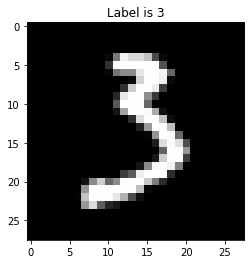

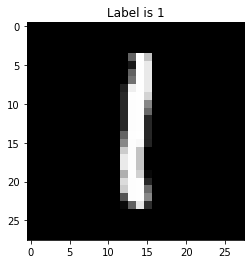

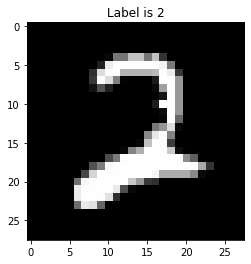

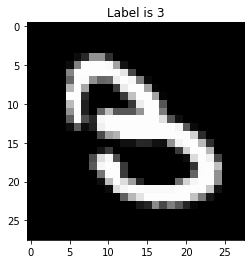

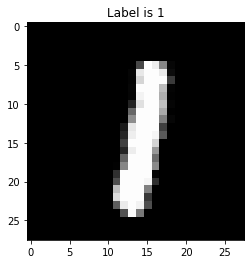

In [302]:
def plot_mnist_img(pixels, label):    
    pixels = pixels.numpy()
    pixels = pixels.reshape((28, 28))
    
    plt.figure()
    plt.title(f"Label is {label}")
    plt.imshow(pixels, cmap="gray")
    
for _ in range(5):
    rand_item = random.choice(mnist_test_set)
    pixels_tensor, label = rand_item
    
    plot_mnist_img(pixels_tensor, label)

# Define the Encoder and Decoder Modules

We define our neural network by subclassing `nn.Module`, and initialize the neural network layers in `__init__`. Every `nn.Module` subclass implements the operations on input data in the `forward()` method.

The `forward()` method of the encoder expects as argument a tensor of dimensions *batch_dim* x 28 x 28, and infers the mean and log variance of the latent space Gaussians. Conversely, the decoder takes a tensor of dimensions *batch_dim* x *latent_space_size* and reconstructs the original image.

In [273]:
class Encoder(nn.Module):
    def __init__(self, z_dim, hidden_dim):
        super().__init__()
        
        # Setup three linear transformations
        self.fc1 = nn.Linear(784, hidden_dim)
        self.fc21 = nn.Linear(hidden_dim, z_dim)
        self.fc22 = nn.Linear(hidden_dim, z_dim)
        
        # Setup the non-linearities
        self.softplus = nn.Softplus()

    def forward(self, x):
        # Define the forward computation on the image x
        # First shape the mini-batch to have pixels in the rightmost dimension
        x = x.reshape(-1, 784)
        
        # Then compute the hidden units
        hidden = self.softplus(self.fc1(x))
        
        # Return a mean vector and a the log variance
        # each of size batch_size x z_dim
        z_loc = self.fc21(hidden)
        z_logvar = self.fc22(hidden)
        
        return z_loc, z_logvar

In [275]:
class Decoder(nn.Module):
    def __init__(self, z_dim, hidden_dim):
        super().__init__()
        
        # Setup the two linear transformations used
        self.fc1 = nn.Linear(z_dim, hidden_dim)
        self.fc21 = nn.Linear(hidden_dim, 784)
        
        # Setup the non-linearities
        self.softplus = nn.Softplus()
        self.sigmoid = nn.Sigmoid()

    def forward(self, z):
        # Define the forward computation on the latent z
        # first compute the hidden units
        hidden = self.softplus(self.fc1(z))
        
        # Return the parameter for the output Bernoulli
        # each is of size batch_size x 784
        loc_img = self.sigmoid(self.fc21(hidden))
        loc_img = loc_img.view(-1, 28, 28)
        
        return loc_img

In [276]:
encoder = Encoder(z_dim=50, hidden_dim=100)
print(encoder)

decoder = Decoder(z_dim=50, hidden_dim=100)
print(decoder)

Encoder(
  (fc1): Linear(in_features=784, out_features=100, bias=True)
  (fc21): Linear(in_features=100, out_features=50, bias=True)
  (fc22): Linear(in_features=100, out_features=50, bias=True)
  (softplus): Softplus(beta=1, threshold=20)
)
Decoder(
  (fc1): Linear(in_features=50, out_features=100, bias=True)
  (fc21): Linear(in_features=100, out_features=784, bias=True)
  (softplus): Softplus(beta=1, threshold=20)
  (sigmoid): Sigmoid()
)


# The Variational Autoencoder in PyTorch

To allow the passage of the gradient, we use the reparameterization trick for the Gaussian distribution:
$$
    \mathbf{z} = \mathbf{\mu} + \mathbf{\sigma} \mathbf{\epsilon}
$$
where $\mathbf{\epsilon} \sim \mathcal{N}(0, 1)$

Our loss function is the ELBO:
$$
    \textrm{ELBO} = \mathbb{E}_{q_{\lambda} (\mathbf{z})} \left[ \log p_{\theta} (\mathbf{x}, \mathbf{z}) - \log q_{\lambda} (\mathbf{z}) \right]
$$
$$
    \textrm{ELBO} = \mathbb{E}_{q_{\lambda} (\mathbf{z})} \left[ \log p_{\theta}(\mathbf{x} \mid \mathbf{z}) \right] - D_{\text{KL}} \left[ q_{\lambda}(\mathbf{z} \mid \mathbf{x}) \mid \mid p_{\theta}(\mathbf{z}) \right]
$$
We've chosen as our variational family a mean-field Gaussian posterior for our latent space. We can thus derive and use the closed form ELBO for Gaussian latents (see [here](https://arxiv.org/pdf/1907.08956.pdf) for a full derivation):
$$
    \mathcal{L} = - \sum_{j=1}^J \frac{1}{2} \left[ 1 + \log \sigma_j^2 - \sigma_j^2 - \mu_j^2 \right] - \frac{1}{L} \sum_l \mathbb{E}_{z \sim q(z \mid x_l)} \left[ \log p (x_l \mid z_l) \right]
$$

In [277]:
class VAEPyTorch(nn.Module):
    def __init__(self, z_dim=50, hidden_dim=400, use_cuda=False):
        super().__init__()
        
        self.encoder = Encoder(z_dim, hidden_dim)
        self.decoder = Decoder(z_dim, hidden_dim)
        
        if use_cuda:
            # calling cuda() here will put all the parameters of
            # the encoder and decoder networks into GPU memory
            self.cuda()
            
        self.use_cuda = use_cuda
        self.z_dim = z_dim
        
    def forward(self, input_data: torch.Tensor):
        mu, logvar = self.encoder(input_data)
        latent_sample = self.reparameterize(mu, logvar)
        reconstructed_inputs = self.decoder(latent_sample)
        
        return input_data, reconstructed_inputs, mu, logvar
    
    def reparameterize(self, mu: torch.Tensor, logvar: torch.Tensor) -> torch.Tensor:
        """
        Reparameterization trick to sample from N(mu, var) from
        N(0,1).
        :param mu: (Tensor) Mean of the latent Gaussian [B x D]
        :param logvar: (Tensor) Standard deviation of the latent Gaussian [B x D]
        :return: (Tensor) [B x D]
        """
        std = torch.exp(0.5 * logvar)
        eps = torch.randn_like(std)
        
        return mu + std * eps
    
    
    def loss_function(
        self, input_data, reconstructions, mu, logvar, beta
    ) -> dict:
        """
        Computes the VAE loss function.
        KL(N(\mu, \sigma), N(0, 1)) = \log \frac{1}{\sigma} + \frac{\sigma^2 + \mu^2}{2} - \frac{1}{2}
        :param args:
        :param kwargs:
        :return:
        """
        recons_loss = torch_functional.mse_loss(reconstructions, input_data)
        kld_loss = torch.mean(-0.5 * torch.sum(1 + logvar - mu ** 2 - logvar.exp(), dim = 1), dim = 0)

        loss = recons_loss + beta * kld_loss
        
        return {"total_loss": loss, "reconstruction_loss": recons_loss.detach(), "KLD": -kld_loss.detach()}

Now that we have our data and our model we can proceed with training.


Inside the training loop, optimization happens in three steps:
 - Call `optimizer.zero_grad()` to reset the gradients of model parameters. Gradients by default add up; to prevent double-counting, we explicitly zero them at each iteration.
 - Backpropagate the prediction loss with a call to `loss.backward()`. PyTorch deposits the gradients of the loss w.r.t. each parameter.
 - Once we have our gradients, we call `optimizer.step()` to adjust the parameters by the gradients collected in the backward pass.

In [ ]:
NUM_EPOCHS = 1
LEARNING_RATE = 0.001

In [ ]:
vae_pytorch = VAEPyTorch(z_dim=50, hidden_dim=100)
optimizer = torch.optim.Adam(vae_pytorch.parameters(), lr=LEARNING_RATE)

In [286]:
for epoch_num in range(NUM_EPOCHS):
    for batch_num, (pixels, _) in enumerate(mnist_train_loader):
        if USE_CUDA:
            pixels = pixels.to("cuda")
            labels = labels.to("cuda")
        
        # Do NOT use directly forward()!
        input_data, reconstructed_inputs, mu, logvar = vae_pytorch(pixels)
        losses = vae_pytorch.loss_function(
            pixels, reconstructed_inputs, mu, logvar, 0.1
        )
        loss = losses["total_loss"]
        
        # Backpropagation and optimization
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        if batch_num % 400 == 0:
            print(f"epoch_num: {epoch_num + 1}; batch_num: {batch_num}; loss: {loss.item():>7f}")    

/tmp/ipykernel_387442/1779618987.py:47: UserWarning: Using a target size (torch.Size([32, 1, 28, 28])) that is different to the input size (torch.Size([32, 28, 28])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  recons_loss = torch_functional.mse_loss(reconstructions, input_data)


epoch_num: 1; batch_num: 0; loss: 0.063515
epoch_num: 1; batch_num: 400; loss: 0.069955
epoch_num: 1; batch_num: 800; loss: 0.071728
epoch_num: 1; batch_num: 1200; loss: 0.065966
epoch_num: 1; batch_num: 1600; loss: 0.069113
epoch_num: 2; batch_num: 0; loss: 0.060997
epoch_num: 2; batch_num: 400; loss: 0.067108
epoch_num: 2; batch_num: 800; loss: 0.064268
epoch_num: 2; batch_num: 1200; loss: 0.065890
epoch_num: 2; batch_num: 1600; loss: 0.070844
epoch_num: 3; batch_num: 0; loss: 0.069434
epoch_num: 3; batch_num: 400; loss: 0.066980
epoch_num: 3; batch_num: 800; loss: 0.067134
epoch_num: 3; batch_num: 1200; loss: 0.066142
epoch_num: 3; batch_num: 1600; loss: 0.064702
epoch_num: 4; batch_num: 0; loss: 0.070319
epoch_num: 4; batch_num: 400; loss: 0.063016
epoch_num: 4; batch_num: 800; loss: 0.064162
epoch_num: 4; batch_num: 1200; loss: 0.067914
epoch_num: 4; batch_num: 1600; loss: 0.070054
epoch_num: 5; batch_num: 0; loss: 0.075909
epoch_num: 5; batch_num: 400; loss: 0.072080
epoch_num: 5

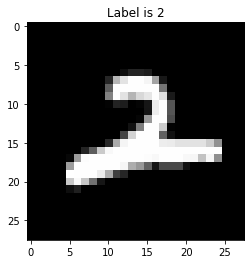

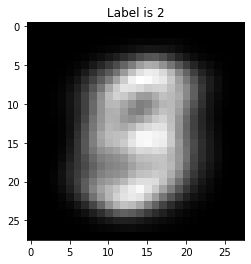

In [306]:
rand_item = random.choice(mnist_test_set)
pixels_tensor, label = rand_item

_, reconstructed_inputs, _, _ = vae_pytorch(pixels_tensor)
reconstructed_pixels = reconstructed_inputs.detach()

plot_mnist_img(pixels_tensor, label)
plot_mnist_img(reconstructed_pixels, label)

# The Variational Autoencoder in Pyro

Probabilistic models in Pyro are specified as Python functions `model(*args, **kwargs)` that generate observed data from latent variables using special primitive functions whose behavior can be changed by Pyro’s internals depending on the high-level computation being performed.

Specifically, the different mathematical pieces of `model()` are encoded via the mapping:
 + latent random variables - `pyro.sample`
 + observed random variables - `pyro.sample` with the `obs` keyword argument
 + learnable parameters - `pyro.param`
 + plates - `pyro.plate` context managers
 
The basic idea behind VI is that we introduce a parameterized distribution $q_{\phi}(\mathbf{z})$ called the variational distribution that will serve as an approximation to the posterior. We can think of $\phi$ as parameterizing a space or family of probability distributions. Our goal will be to find the (not necessarily unique) probability distribution in that space that is the best possible approximation to the posterior distribution.

Just like the model, the guide is encoded as a stochastic function `guide()` that contains `pyro.sample` and `pyro.param` statements, but can't contain observed data. Pyro furthermore enforces that `model()` and `guide()` have the same call signature, i.e. both callables should take the same arguments.

In [311]:
class VAEPyro(nn.Module):
    def __init__(self, z_dim=50, hidden_dim=400, use_cuda=False):
        super().__init__()
        
        # Create the encoder and decoder networks
        self.encoder = Encoder(z_dim, hidden_dim)
        self.decoder = Decoder(z_dim, hidden_dim)

        if use_cuda:
            # calling cuda() here will put all the parameters of
            # the encoder and decoder networks into gpu memory
            self.cuda()
        
        self.use_cuda = use_cuda
        self.z_dim = z_dim

    # Define the model p(x|z)p(z)
    def model(self, x):
        # register PyTorch module `decoder` with Pyro
        pyro.module("decoder", self.decoder)
        
        with pyro.plate("data", x.shape[0]):
            # setup hyperparameters for prior p(z)
            z_loc = x.new_zeros(torch.Size((x.shape[0], self.z_dim)))
            z_scale = x.new_ones(torch.Size((x.shape[0], self.z_dim)))
            
            # sample from prior (value will be sampled by guide when computing the ELBO)
            z = pyro.sample("latent", dist.Normal(z_loc, z_scale).to_event(1))
            
            # decode the latent code z
            loc_img = self.decoder(z).view(-1, 784)
            # score against actual images
            pyro.sample("obs", dist.Bernoulli(loc_img).to_event(1), obs=x.reshape(-1, 784))
        
    # Define the guide (i.e. variational distribution) q(z|x)
    def guide(self, x):
        # register PyTorch module `encoder` with Pyro
        pyro.module("encoder", self.encoder)
        
        with pyro.plate("data", x.shape[0]):
            # use the encoder to get the parameters used to define q(z|x)
            z_loc, logvar = self.encoder(x)
            z_scale = torch.exp(logvar)
            
            # sample the latent code z
            pyro.sample("latent", dist.Normal(z_loc, z_scale).to_event(1))

    # define a helper function for reconstructing images
    def reconstruct_img(self, x):
        # encode image x
        z_loc, logvar = self.encoder(x)
        z_scale = torch.exp(logvar)
        
        # sample in latent space
        z = dist.Normal(z_loc, z_scale).sample()
        
        # decode the image (note we don't sample in image space)
        loc_img = self.decoder(z)
        return loc_img

In [223]:
def train(svi, train_loader, use_cuda=False):
    # initialize loss accumulator
    epoch_loss = 0.
    # do a training epoch over each mini-batch x returned
    # by the data loader
    for x, _ in train_loader:
        # if on GPU put mini-batch into CUDA memory
        if use_cuda:
            x = x.cuda()
        # do ELBO gradient and accumulate loss
        epoch_loss += svi.step(x)

    # return epoch loss
    normalizer_train = len(train_loader.dataset)
    total_epoch_loss_train = epoch_loss / normalizer_train
    
    return total_epoch_loss_train

In [224]:
def evaluate(svi, test_loader, use_cuda=False):
    # initialize loss accumulator
    test_loss = 0.
    # compute the loss over the entire test set
    
    for x, _ in test_loader:
        # if on GPU put mini-batch into CUDA memory
        if use_cuda:
            x = x.cuda()
        # compute ELBO estimate and accumulate loss
        test_loss += svi.evaluate_loss(x)
    
    normalizer_test = len(test_loader.dataset)
    total_epoch_loss_test = test_loss / normalizer_test
    
    return total_epoch_loss_test

In [225]:
train_loader, test_loader = mnist_train_loader, mnist_test_loader

# clear param store
pyro.clear_param_store()

# setup the VAE
vae = VAEPyro(use_cuda=USE_CUDA)

# setup the optimizer
adam_args = {"lr": LEARNING_RATE}
optimizer = Adam(adam_args)

# setup the inference algorithm
svi = SVI(vae.model, vae.guide, optimizer, loss=Trace_ELBO())

train_elbo = []
test_elbo = []
# training loop
for epoch in range(NUM_EPOCHS):
    total_epoch_loss_train = train(svi, train_loader, use_cuda=USE_CUDA)
    train_elbo.append(-total_epoch_loss_train)
    print("[epoch %03d]  average training loss: %.4f" % (epoch, total_epoch_loss_train))

    if epoch % TEST_FREQUENCY == 0:
        # report test diagnostics
        total_epoch_loss_test = evaluate(svi, test_loader, use_cuda=USE_CUDA)
        test_elbo.append(-total_epoch_loss_test)
        print("[epoch %03d] average test loss: %.4f" % (epoch, total_epoch_loss_test))

KeyboardInterrupt: 

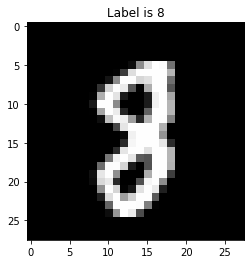

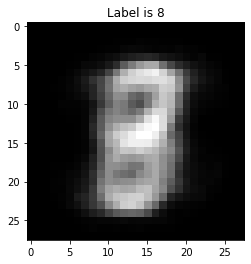

In [314]:
rand_item = random.choice(mnist_test_set)
pixels_tensor, label = rand_item

reconstructed_inputs = vae.reconstruct_img(pixels_tensor)
reconstructed_pixels = reconstructed_inputs.detach()

plot_mnist_img(pixels_tensor, label)
plot_mnist_img(reconstructed_pixels, label)

# References


https://pyro.ai/examples/vae.html
https://pytorch.org/tutorials/beginner/basics/intro.html
